# Resolved Mass-Metallicity Relation with MaNGA

We're going to construct a spatially-resolved mass-metallicity relation for a MaNGA galaxy.

## Key Terms

**DAP**: MaNGA Data Analysis Pipeline, which fits the MaNGA data cubes with stellar continuum and emission line models to produce model data cubes and maps of measured quantities.  
**data cube**: 3D data structure with 1D spectra arranged in a 2D spatial grid  
**IFU**: integral field unit  
**spaxels**: spatial pixels

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Load Maps for Galaxy

In [2]:
from marvin.tools.maps import Maps

INFO: No release version set. Setting default to MPL-6


In [3]:
# filename = ''
# maps = Maps(filename=filename)
maps = Maps('8485-1901')

## Select Only Star-forming Spaxels

Metallicity indicators only work for star-forming spaxels, so we need a way to select only these spaxels.

## BPT Diagram

The classic diagnostic diagram for classify the emission from galaxies (or galactic sub-regions) as star-forming or non-star-forming (i.e., from active galactic nuclei (AGN) or evolved stars) was originally proposed in Baldwin, Phillips, & Terlevich (1981) and is known as the BPT diagram.

The BPT diagram uses ratios of emission lines separate thermal and non-thermal emission.

The classic BPT diagram uses [OIII]5007 / Hbeta vs. [NII]6583 / Halpha, but there are several versions of the BPT diagram that use different lines ratios.

<img src="bpt_kauffmann2003.png" style="width: 400px;"/>

Dashed line: Kauffmann et al. (2003). Dotted line: Kewley et al. (2001).

## BPT Diagrams with Marvin

Let's use Marvin's `get_bpt()` method to make BPT diagrams for this galaxy.

**red line**: maximal starbust (Kewley et al 2001) -- everything to the right is non-star-forming.  
**dashed black line**: conservative star-forming cut (Kauffmann et al. 2003) -- everything to the left is star-forming.

Line ratios that fall in between these two lines are designated "Composite" with contributions from both star-forming and non-star-forming emission.

**blue line**: separates non-star-forming spaxels into Seyferts and LINERs.

Seyferts are a type of AGNs.

LINERs (Low Ionization Nuclear Emission Regions) are not always nuclear (LIER is a better acronym) and not always AGN (oftern hot evolved stars).

Sometimes these diagnostic diagrams disagree with each other, hence the "Ambiguous" designation.

In [ ]:
masks_bpt, __, __ = maps.get_bpt()

In [ ]:
# Marvin can do map arithmetic.
# It propagates the masks and inverse variances.
n2 = nii / ha

# This does not propagate the inverse variance properly (yet).
logn2 = np.log10(n2)

## Measuring Metallicity

Metallicities have large systematic uncertainties.

Direct method vs. photoionization models
Empirical vs. Theoretical calibrations


<img src="images/kewley2008.png" style="width: 400px;"/>

Mass-metallicity relations for various metallicity calibrations from Kewley et al. (2008).
- Lines (1)-(4) are theoretical calibrations. 
- Lines (5)-(8) are mostly empirical calibrations.
- Lines (9)-(10) are purely empirical calibrations.

### Pettini & Pagel (2004) N2 metallicity diagnostic

12 + log (O/H) = 8.90 + 0.57 × N2,

where N2 = log( flux( [NII] 6585 ) / flux( Halpha ) )

In [55]:
# Get [NII] 6585 and Halpha maps.
# note: MaNGA (and Marvin) use the wavelengths of lines in vaccuum,
# whereas they are usually reported in air, hence the slight offsets
nii = maps.emline_gflux_nii_6585
ha = maps.emline_gflux_ha_6564

In [ ]:
# Use Pettini & Pagel (2004) N2 metallicity calibration
oh = 8.90 + 0.57 * logn2

In [ ]:
# This is a boolean array (True/False), where spaxels that are classified
# as star-forming in all three BPT diagrams are designated as ``True``.
masks_bpt['sf']['global']

### Masks
MaNGA (and SDSS generally) use bitmasks to communicate data quality.

Marvin has built-in methods to convert from the bitmasks integer values to individual bits or labels and to create new masks by specifying a set of labels.

In [ ]:
# describes mask schema
n2.pixmask.schema

In [ ]:
# Select non-star-forming spaxels and set their mask value to the DAP's DONOTUSE value.
mask_non_sf = ~masks_bpt['sf']['global'] * n2.pixmask.labels_to_value('DONOTUSE')

# Select spaxels classified by the DAP as bad data according to the masks for
# spaxels with no IFU coverage, with unreliable measurements, or otherwise
# unfit for science.
mask_bad_data = n2.pixmask.get_mask(['NOCOV', 'UNRELIABLE', 'DONOTUSE'])

# Select spaxels with low signal-to-noise ratios (SNRs).
# ivar = inverse variance = 1 / sigma**2, where sigma is the error.
min_snr = 3.
mask_nii_low_snr = (np.abs(nii.value * np.sqrt(nii.ivar)) < min_snr)
mask_ha_low_snr = (np.abs(ha.value * np.sqrt(ha.ivar)) < min_snr)

# Do a bitwise OR to create a master mask of spaxels to ignore.
mask = mask_non_sf | mask_bad_data | mask_nii_low_snr | mask_ha_low_snr

## Plot the Metallicity Map
Note: solar metallicity is about 8.7.

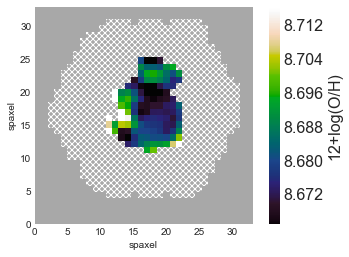

In [77]:
fig, ax = oh.plot(mask=mask, cblabel='12+log(O/H)')

## Local Stellar Surface Density



In [61]:
import os
from os.path import join
path_notebooks = os.path.abspath('.')
path_data = join(os.path.split(path_notebooks)[0], 'data')

In [71]:
import pandas as pd
mstar = pd.read_csv(join(path_data, 'manga-8485-1901_mstar.csv'))

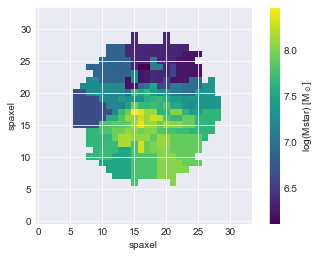

In [76]:
fig, ax = oh.plot(mask=mask, cblabel='12+log(O/H)')

### Jorge's resolved MZR
